In [3]:
import glob, os
import xarray
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
fs=14
plt.rc("font",size=fs)

In [4]:
import numpy.matlib

In [5]:
filter_meters = 333.*6
kappa_cut = 1/float(filter_meters)
wrf_dx = 25.0
wrf_dy = 25.0

In [6]:
inpath = "/glade/scratch/doubrawa/post_processing/"

In [13]:
fnames = sorted(glob.glob(os.path.join(inpath,"WRF_LES_25m_3D_*03-*0.nc")))

### the hamming filter only needs to be created once -- create it now

In [8]:
Nx = 1200
Ny = 1200

# combo of uniform window in the middle and hamming window on edges:
npts_buffer = 50 

# create a 1-d hamming window : hamm_1d.shape = (100,)
hamm_1d     = np.hamming(npts_buffer*2)
# repeat it : B.shape = (100, 100)
B           = np.matlib.repmat(hamm_1d,npts_buffer*2,1)
# transpose it : C.shape = (100,100)
C           = np.transpose(B)
# now get the two-dimensional hamming window : hamm_2d_s.shape = (100,100)
hamm_2d_s   = B*C

# allocate space for the final 2d-filter
hamm_2d = np.zeros([Ny,Nx])

# fill it with ones (no filter) anywhere that the window won't be applied (inside the domain, anywhere inside the buffer)        
for ii in range(0+npts_buffer,Nx-npts_buffer):
    for jj in range(0+npts_buffer,Ny-npts_buffer):
        hamm_2d[jj,ii] = 1.0
        
# now put the filter values in there

# south west corner
hamm_2d[0:npts_buffer,0:npts_buffer] = hamm_2d_s[0:npts_buffer,0:npts_buffer]

# south east corner
hamm_2d[0:npts_buffer,Nx-npts_buffer:Nx] = hamm_2d_s[0:npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

# north west corner
hamm_2d[Ny-npts_buffer:Ny,0:npts_buffer] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,0:npts_buffer]

# north east corner
hamm_2d[Ny-npts_buffer:Ny,Nx-npts_buffer:Nx] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

# south boundary
hann_tmp = hamm_1d[0:npts_buffer]
len_tmp  = Nx-2*npts_buffer
hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
hann_tmp = np.transpose(hann_tmp)
hamm_2d[0:npts_buffer,npts_buffer:Nx-npts_buffer] = hann_tmp

# north boundary
hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
len_tmp  = Nx-2*npts_buffer
hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
hann_tmp = np.transpose(hann_tmp)
hamm_2d[Ny-npts_buffer:Ny,npts_buffer:Nx-npts_buffer] = hann_tmp

# west boundary
hann_tmp = hamm_1d[0:npts_buffer]
len_tmp  = Ny-2*npts_buffer
hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
hamm_2d[npts_buffer:Ny-npts_buffer,0:npts_buffer] = hann_tmp

# east boundary
hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
len_tmp  = Ny-2*npts_buffer
hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
hamm_2d[npts_buffer:Ny-npts_buffer,Nx-npts_buffer:Nx] = hann_tmp

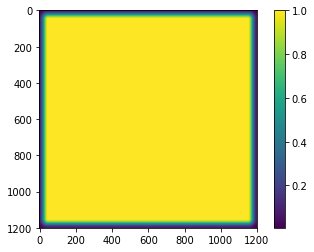

In [9]:
plt.imshow(hamm_2d);plt.colorbar()

### prepare a butterworth filter

In [10]:
n_ord = 12 # order of the Butterworth filter
x_len = Nx
y_len = Ny
kappas_1dx = fftpack.fftfreq(x_len,d=wrf_dx)
kappas_1dy = fftpack.fftfreq(y_len,d=wrf_dx)
[kx_2d,ky_2d] = np.meshgrid(kappas_1dx,kappas_1dy)
k_xy_2d = np.sqrt(np.power(kx_2d,2.0)+np.power(ky_2d,2.0))
BWnth_2d_f = 1.0/(np.sqrt(1.0+(np.power(k_xy_2d/kappa_cut,2*n_ord))))

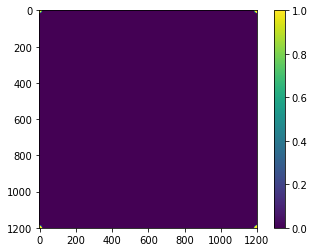

In [11]:
plt.imshow(BWnth_2d_f); plt.colorbar()

In [23]:
fnames = fnames[0:60] + fnames[120:]

In [25]:
for fname in fnames:
    
    print(fname)
    data = xarray.open_dataset(fname)
    nk, nj, ni = data.u.shape    
    filt_dict = {}
    
    for varname in ["u","v","w","theta"]:
        print(varname)
        filtered = np.zeros((nk,nj,ni))
        for k in range(nk):
            
            # 1. get 2-d array
            tmp = data[varname].isel(bottom_top=k).data
            
            # 2. remove spatial mean
            tmp_mean = np.mean(tmp)
            tmp = tmp - tmp_mean
            
            # 3. apply window (to minimize noise since the arrays are not periodic in space)
            tmp = tmp*hamm_2d
            
            # 4. apply fft
            psd_2d = fftpack.fft2(tmp)

            # 5. apply butterworth filter (instead of sharp filter, to minimize ringing effect near cut-off wavenumber)
            psd_2d = np.squeeze(psd_2d)*BWnth_2d_f
            
            # 6. invert to get the array back and put it in the kth index of the previously allocated 3-d array
            filtered[k,...] = fftpack.ifft2(psd_2d).real + tmp_mean

        # now turn that filtered array into a xarray datarray    
        filt_dict[varname+"_filt"] = xarray.DataArray(filtered, 
                                                      coords=data[varname].coords, 
                                                      dims=data[varname].dims)
    # now turn all those xarray dataarrays into an xarray dataset
    all_data = data.merge(xarray.Dataset(filt_dict))
    fout = os.path.join(inpath,os.path.split(fname)[-1].split('.nc')[0]+"_plus_filtered.nc")
    print("===> {0}".format(fout))
    all_data.to_netcdf(fout)

/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_15:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_16:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_17:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_19:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_20:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_21:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_22:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_23:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_14:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_15:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_16:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_17:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_19:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_20:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_21:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_22:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-28_23:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_14:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_15:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_16:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_17:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_19:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_20:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_21:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_22:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-29_23:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_14:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_15:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_16:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_17:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_19:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_20:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_21:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_22:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:00.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:10.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:20.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:20_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:30.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:30_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:40.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:40_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:50.nc
u


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


v
w
theta
===> /glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-30_23:50_plus_filtered.nc


### compare filtered vs. not filtered

In [39]:
k = 8
varname = "w"

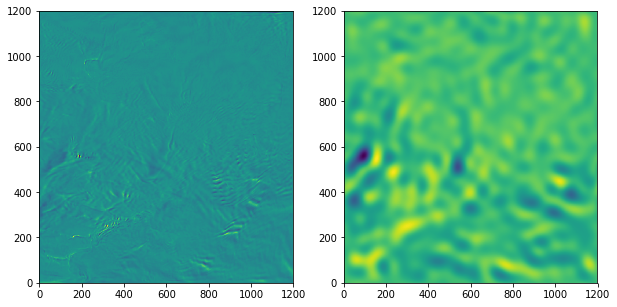

In [46]:
fig = plt.figure(figsize=(2*5, 5))

x = data[varname].west_east.data
y = data[varname].south_north.data
z = data[varname].isel(bottom_top=k).data

ax1 = fig.add_subplot(121)
ax1.pcolormesh(x,y,z)

x = all_data[varname+"_filt"].west_east.data
y = all_data[varname+"_filt"].south_north.data
z = all_data[varname+"_filt"].isel(bottom_top=k).data

ax2 = fig.add_subplot(122)
ax2.pcolormesh(x,y,z)
